In [1]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt

In [2]:
def get_image(start, end):
    frames = []
    cap = cv2.VideoCapture('videos\cam_video_1.mp4')
    for i in [start, end]:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        frames.append(frame)
    cap.release()
    return frames

In [3]:
def motion_constraint(Iref, Inext):
    kernel_x = np.array([[-1, 1], [-1, 1]])*.25
    kernel_y = np.array([[-1, -1], [1, 1]])*.25
    kernel_t = np.array([[1, 1], [1, 1]])*.25

    Iref = Iref.astype(np.float32)/255
    Inext = Inext.astype(np.float32)/255
    mode = 'same'
    Ix = signal.convolve2d(Iref, kernel_x, mode=mode, boundary='symm')
    Iy = signal.convolve2d(Iref, kernel_y, mode=mode, boundary='symm')
    It = signal.convolve2d(Inext, kernel_t, mode=mode, boundary='symm') + signal.convolve2d(Iref, -kernel_t, mode=mode, boundary='symm') 
    return Ix, Iy, It 

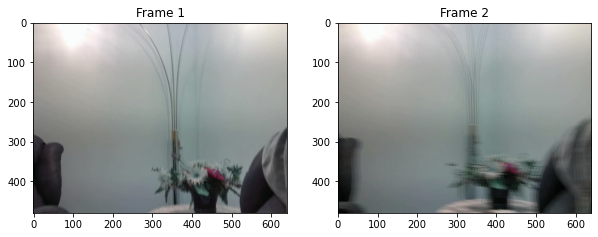

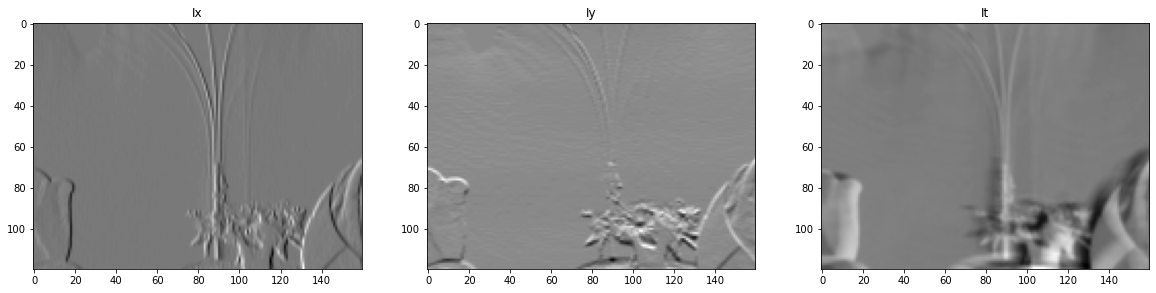

In [4]:
frames = get_image(158, 160)
size = frames[0].shape
gray_frames = [cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (int(size[1]/4), int(size[0]/4)), interpolation=cv2.INTER_AREA) for frame in frames]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(frames[0], cmap='gray')
plt.title('Frame 1')
plt.subplot(1, 2, 2)
plt.imshow(frames[1], cmap='gray')
plt.title('Frame 2')
plt.show()

Ix, Iy, It = motion_constraint(gray_frames[0], gray_frames[1])

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(Ix, cmap='gray')
plt.title('Ix')
plt.subplot(1, 3, 2)
plt.imshow(Iy, cmap='gray')
plt.title('Iy')
plt.subplot(1, 3, 3)
plt.imshow(It, cmap='gray')
plt.title('It')
plt.show()

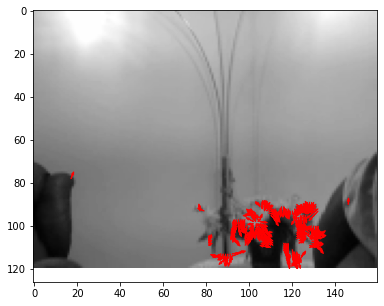

In [5]:
def lucase_kanade(Iref, Inext, fx, fy, ft, window_size=5, tau=1.5e-2):
    w = window_size // 2
    u = np.zeros(Iref.shape)
    v = np.zeros(Iref.shape)

    # run convolution
    for i in range(w, Iref.shape[0] - w):
        for j in range(w, Iref.shape[1] - w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = np.reshape(It, (It.shape[0], 1)) * -1
            A = np.vstack((Ix, Iy)).T

            # solve for velocity
            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
                u[i,j]=nu[0]
                v[i,j]=nu[1]

    plt.figure(figsize=(10, 5))
    plt.imshow(Iref, cmap='gray')

    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            if abs(u[i, j]) > 0.1 or abs(v[i, j]) > 0.1:
                plt.arrow(j, i, u[i, j], v[i, j], color='r', head_width=1)
    return u, v

u,v = lucase_kanade(gray_frames[0], gray_frames[1], Ix, Iy, It)


In [6]:
def get_optical_flow(start, end, step=1):
    for i in range(start, end, step):
        frames = get_image(i, i+step)
        size = frames[0].shape
        gray_frames = [cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (int(size[1]/4), int(size[0]/4)), interpolation=cv2.INTER_AREA) for frame in frames]
        Ix, Iy, It = motion_constraint(gray_frames[0], gray_frames[1])
        u, v = lucase_kanade(gray_frames[0], gray_frames[1], Ix, Iy, It)
        plt.show()


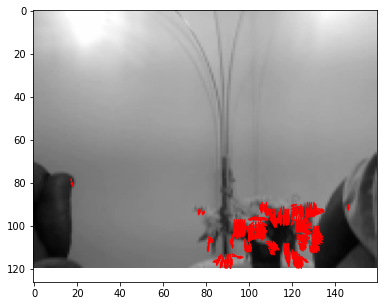

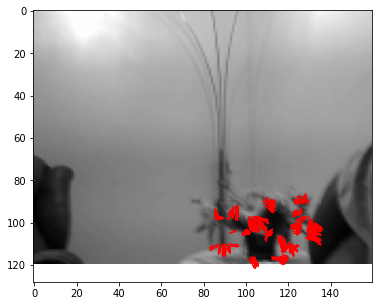

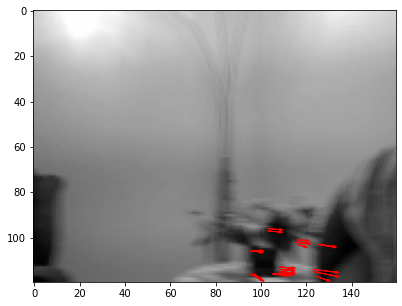

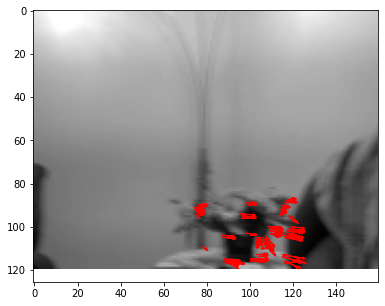

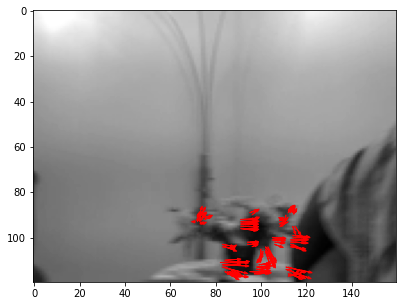

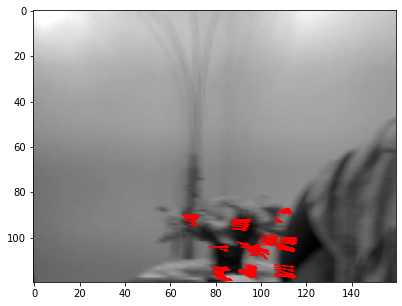

In [7]:
get_optical_flow(158, 164)

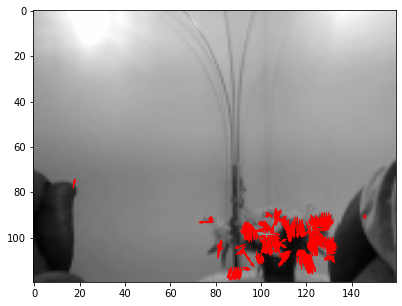

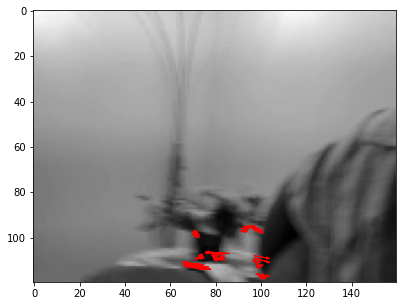

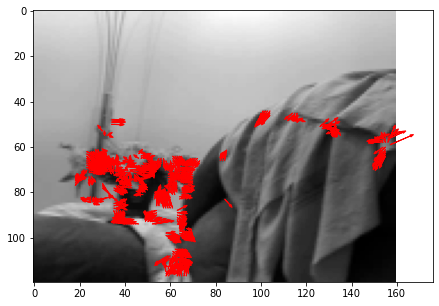

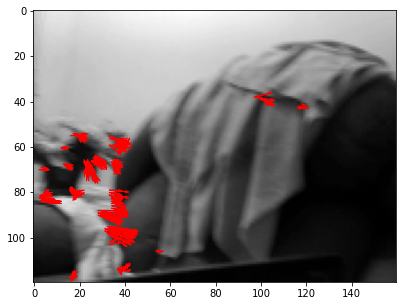

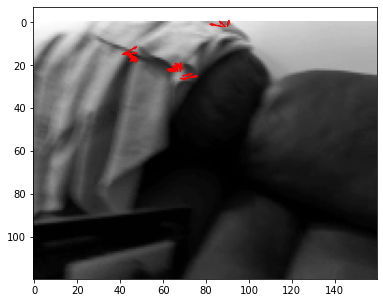

In [8]:
get_optical_flow(158, 210, 11)

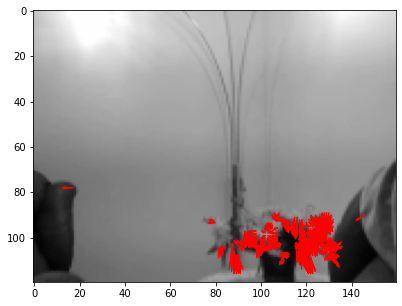

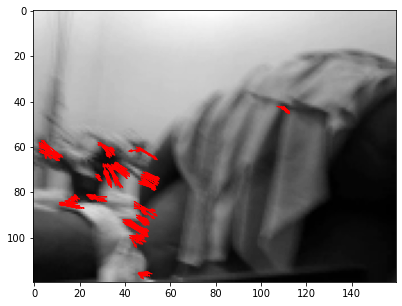

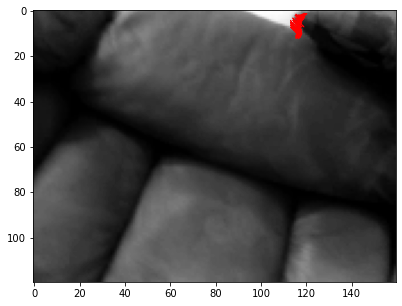

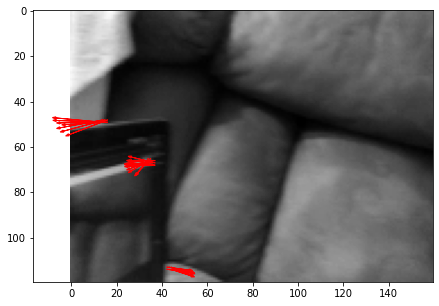

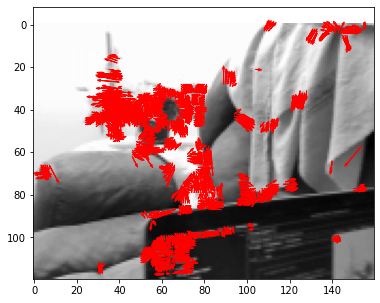

In [9]:
get_optical_flow(158, 300, 31)